# Set up environment

In [1]:
%matplotlib inline

import anndata as ad
import ast
import copy
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import geopandas as gpd
import gseapy
import hdf5plugin
import importlib
import itertools
from math import sqrt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from multiprocessing import Pool
import numpy as np
from numpy.polynomial import Polynomial
import os
import pandas as pd
import pickle as pk
import random
import scanpy as sc
import scipy
from scipy import spatial
from scipy.spatial import cKDTree
from scipy.spatial import distance
from scipy.stats import fisher_exact, ks_2samp
from sklearn.cluster import KMeans
import seaborn as sns
from shapely.geometry import Point
import skbio
import slide_tcr_functions
import squidpy as sq
from statistics import mean, stdev
import statsmodels.stats
from statsmodels.stats import multitest
from statsmodels.nonparametric.smoothers_lowess import lowess
import sys
import time
from tqdm.notebook import tqdm
from scipy.interpolate import make_interp_spline
from collections import defaultdict
from numpy.polynomial.polynomial import Polynomial

from alphashape import alphashape
from collections import Counter
from functools import partial
from libpysal.weights import KNN
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from perm_test_functions import perm_test_to_final_plot
from plotting_functions import gaussian_heat_plot, plot_cortex_medulla
from shapely.geometry import Point
from slide_tcr_functions import (
    PuckReplicate,
    save_puck,
    load_puck,
    make_puck,
    make_adata,
    load_adata,
    pkl_load,
    pkl_dump
)
from statsmodels import stats
from tcr_mapping import tcr_mapping, get_barcode_position, build_6mer_dist, barcode_matching

# Set directory paths
directory = '../data/'  # Directory with all data
output_directory = '../results/'

# Set plotting parameters
fontprops = fm.FontProperties(size=18)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['ps.fonttype'] = 42

pixels_needed = 500 / 0.65

master_df = pd.read_csv(f'{directory}Sample_information.csv', header=0)

# Initialize dictionaries and lists
csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

# Process rows in the master dataframe
for index, row in master_df.iterrows():
    puck_name = row['NovaSeq alignment directory']
    age = row['Sample Age']

    # Skip rows with specified Barcodes to TCR csv values
    csv_name = f'{puck_name[11:25]}_B.csv'

    # Populate dictionaries and lists
    csv_name_to_puck_name[csv_name] = puck_name
    csv_names.append(csv_name)
    puck_name_to_timepoint[puck_name] = age

    if age not in age_to_ss:
        age_to_ss[age] = []
    age_to_ss[age].append(row['NovaSeq alignment directory'])
    puck_to_time[puck_name] = age

# Define mappings and orderings
time_to_puck = {puck_to_time[i]: i for i in puck_to_time}

# Define timepoints, day mappings, and puck names

tpt_to_pn = {
    i: j
    for i, j in zip(master_df['Sample Age'],
                    master_df['NovaSeq alignment directory'])
}
tpt_order = [
    '0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day',
    '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks',
    '28wks', '32wks', '48 wks', '68 wks', '90wks'
]

timepoints = [
    '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day',
    '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks',
    '32wks', '48 wks', '68 wks', '90wks'
]
tpt_to_day = {
    '0 day': 0,
    '1 day': 1,
    '2 day': 2,
    '3 day': 3,
    '4 day': 4,
    '5 day': 5,
    '7 day': 7,
    '10 day': 10,
    '13 day': 13,
    '3wks': 3 * 7,
    '4 wks': 4 * 7,
    '5 wks': 5 * 7,
    '7wks': 7 * 7,
    '9 wks': 9 * 7,
    '13 wks': 13 * 7,
    '15wks': 15 * 7,
    '28wks': 28 * 7,
    '32wks': 32 * 7,
    '48 wks': 48 * 7,
    '68 wks': 68 * 7,
    '90wks': 90 * 7
}

puck_names = ["2023-01-24_Puck_221024_23", # 0 day
                      "2022-11-23_Puck_221024_24", # 0 day
                "2022-11-23_Puck_221024_31", # 1 day
                      "2023-01-16_Puck_221024_27", # 1 day
                      "2022-11-23_Puck_221024_34", # 2 day
                      "2023-01-24_Puck_221024_33", # 2 day
                      "2023-01-24_Puck_221024_36", # 2 day
                      "2022-11-23_Puck_221024_38", # 3 day
                      "2023-01-24_Puck_221024_37", # 3 day
                      "2023-01-24_Puck_221024_39", # 3 day
                      "2023-01-24_Puck_221103_09", # 4 day
                      "2023-01-24_Puck_221103_12", # 4 day
                      "2023-01-24_Puck_221019_08", # 5 day
                      "2023-01-24_Puck_221019_05", # 5 day
                      "2023-01-24_Puck_221019_10", # 7 day
                      "2023-01-24_Puck_221019_14", # 7 day
                      "2022-12-16_Puck_221006_22_trunc", # 10 day
                      "2023-01-24_Puck_221006_23", # 10 day
                      "2022-12-16_Puck_221011_32_trunc", # 13 day
                      "2022-12-16_Puck_221011_33_trunc", # 13 day
                      "2023-01-24_Puck_221118_38", # 3 weeks
                      "2023-01-24_Puck_221118_39", # 3 weeks
                      "2023-01-24_Puck_221103_22", # 4 weeks
                      "2023-01-24_Puck_221118_40", # 4 weeks
                      "2023-01-24_Puck_220930_18", # 5 weeks
                      "2023-01-24_Puck_220930_20", # 5 weeks
                      "2023-01-24_Puck_220930_22", # 5 weeks
                      "2023-01-24_Puck_220930_23", # 7 weeks
                      "2023-01-24_Puck_220930_28", # 7 weeks
                      "2023-01-24_Puck_221011_37", # 9 weeks
                      "2023-01-24_Puck_221011_39", # 9 weeks
                      "2023-01-24_Puck_221011_12", # 13 weeks
                      "2023-01-24_Puck_221011_13", # 13 weeks
                      "2022-11-04_Puck_221006_24", # 15 week
                      "2022-12-16_Puck_221006_26_trunc", # 15 week
                      "2022-11-04_Puck_221006_29", # 28 week
                      "2022-12-16_Puck_221006_35_trunc", # 28 week
                      "2022-11-04_Puck_220930_32", # 32 week
                      "2022-12-16_Puck_220930_29_trunc", # 32 week
                      "2023-01-24_Puck_220930_35", # 32 week
                      "2023-01-24_Puck_221014_37", # 48 week
                      "2023-01-24_Puck_221019_03", # 48 week
                      "2022-12-16_Puck_221011_19_trunc", # 68 week
                      "2022-12-16_Puck_221011_20_trunc", # 68 week
                      "2023-01-24_Puck_221006_32", # 68 week
                      "2022-12-16_Puck_220930_37_trunc", # 90 week
                      "2022-12-16_Puck_220930_38_trunc"] # 90 week

puck_times = [0,0,1,1,2,2,2,3,3,3,4,4,5,5,7,7,10,10,13,13,3*7,3*7,4*7,4*7,5*7,5*7,5*7,
              7*7,7*7,9*7,9*7,13*7,13*7,15*7,15*7,28*7,28*7,32*7,32*7,32*7,48*7,48*7,68*7,68*7,68*7,90*7,90*7]


puck_name_to_days = dict(zip(puck_names, puck_times))

# Define batch mappings
batch_to_tpt = dict(zip(range(len(puck_times)), puck_times))
batch_to_puck_name = dict(zip(range(len(puck_times)), puck_names))
puck_to_batch = dict(zip(puck_names, range(len(puck_times))))

def calculate_morans_i(x,y,label,label_of_interest):
    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(x, y)]
    gdf = gpd.GeoDataFrame({'x': x, 'y': y, 'label': label}, geometry = geometry)

    # Create spatial weights matrix using K-nearest neighbors
    k = 5  # You can adjust the number of neighbors (k) as needed
    w = KNN.from_dataframe(gdf, k=k)

    # Calculate Moran's I for subset
    moran_ct1 = Moran(gdf['label'].apply(lambda x: 1 if x == label_of_interest else 0), w)

    # Print the Moran's I statistics
    print(f"Moran's I for {label_of_interest} Points:")
    print("I:", moran_ct1.I)
    print("Expected I:", moran_ct1.EI)
    print("p-value:", moran_ct1.p_sim)

    return moran_ct1.I

def find_indices(lst, target_item):
    return [index for index, item in enumerate(lst) if item == target_item]

def dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1,
                         loc_to_bc_s1, matched_bead_barcodes,
                         loc_to_diversity, title, filt_plot=False,
                         show_plot=True):
    """
    Dilate cortex points based on the median diversity of nearby points.

    Parameters:
    - bc_cortex: List of cortex barcodes
    - bc_medulla: List of medulla barcodes
    - bc_loc_dict_s1: Dictionary mapping barcodes to locations
    - loc_to_bc_s1: Dictionary mapping locations to barcodes
    - matched_bead_barcodes: List of matched bead barcodes
    - locs_cortex: List of cortex locations
    - filt_plot: Boolean flag to filter the plot

    Returns:
    - Dictionary mapping cortex locations to diluted diversity values
    """

    # Extract cortex locations
    cortex_locs = [bc_loc_dict_s1[bc] for bc in bc_cortex]

    # Extract all locations (cortex + medulla)
    everywhere_locs = [bc_loc_dict_s1[bc] for bc in bc_medulla + bc_cortex]

    # If there are fewer than 2 cortex locations, skip dilation
    if len(cortex_locs) < 2:
        return 'Skip'

    point_tree = cKDTree(cortex_locs)

    # Create a copy of loc_to_diversity for cortex locations
    cort_loc_to_diversity = copy.deepcopy(loc_to_diversity)

    # Iterative dilation process
    num_iter = 0
    while num_iter != 2:  # Limiting the number of iterations for demonstration (can be adjusted)
        num_iter += 1
        # print(f"Iteration: {num_iter}")
        # print(f"Number of Cortex Locations: {len(cort_loc_to_diversity)}")

        # Find unassigned cortex locations
        unassigned_cortex_locs = [loc for loc in cortex_locs if loc not in cort_loc_to_diversity]

        # Dilate unassigned cortex locations
        for loc in unassigned_cortex_locs:
            # Find points within a radius of 20 units
            idx_closeby_points = point_tree.query_ball_point(loc, r=20 / 0.65)
            nearest_points = [cortex_locs[idx] for idx in idx_closeby_points]

            # Extract diversity values for nearby points
            div = [cort_loc_to_diversity[i] for i in nearest_points if i in cort_loc_to_diversity]

            # If there are diversity values, assign the median to the current location
            if len(div) > 0:
                cort_loc_to_diversity[loc] = np.median(div)

        # Make a plot
        if (show_plot & num_iter==2):
            print('success')
            plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, title, filt_plot)
    return cort_loc_to_diversity


def plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, title, filt_plot, vmin=3.3, vmax=5.4):
    """
    Plot the dilated cortex.

    Parameters:
    - cort_loc_to_diversity: Dictionary mapping cortex locations to diluted diversity values
    - everywhere_locs: List of all locations (cortex + medulla)
    - cortex_locs: List of cortex locations
    - locs_cortex: List of cortex locations for filtering
    - filt_plot: Boolean flag to filter the plot
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot everywhere locations in gray
    x2, y2 = zip(*everywhere_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.05)  # Everywhere

    # Plot cortex locations in gray with higher alpha
    x2, y2 = zip(*cortex_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.2)

    # Plot dilated cortex locations
    if filt_plot:
        locs_filt, c = zip(*[(loc, c) for loc, c in zip(list(cort_loc_to_diversity.keys()), list(cort_loc_to_diversity.values())) if loc in cortex_locs])
        x, y = zip(*locs_filt)
    else:
        x, y = zip(*list(cort_loc_to_diversity.keys()))
        c = list(cort_loc_to_diversity.values())

    # Scatter plot with color map
    p = plt.scatter(x, y, c=c, s=1, cmap='inferno', vmin=vmin, vmax=vmax)

    # Additional plot settings
    plt.axis('off')
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])
    plt.title(title)
    cb_ax = fig.add_axes([.91, .124, .04, .754])
    fig.colorbar(p, orientation='vertical', cax=cb_ax)
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.show()

def plot_gene_expression_on_pucks(adata_all, pucks_to_plot, genes_to_plot,title_name = None):
    """
    Plot gene expression on specified pucks for selected genes.

    Parameters:
    - pucks_to_plot: List of puck names to be plotted
    - genes_to_plot: List of gene names to be plotted

    Returns:
    - None
    """
    vmax_calc = {i: [] for i in genes_to_plot}
    vmax_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    vmin_calc = {i: [] for i in genes_to_plot}
    vmin_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    all_x_agg = {}
    all_y_agg = {}
    all_adata_filt = {}
    all_total_counts = {}

    # Calculate vmax values
    for pn in tqdm(pucks_to_plot):
        if pn not in loaded_pucks:
            adata = adata_all[adata_all.obs.puck_name == pn]
        else:
            adata = loaded_pucks[pn]
        all_x = adata.obs['x_val']
        all_y = adata.obs['y_val']

        all_x_agg[pn] = all_x
        all_y_agg[pn] = all_y

        adata = adata[adata.obs['cortex_medulla'].isin(['cortex', 'medulla'])]  # clean up areas outside tissue
        all_adata_filt[pn] = adata

        total_counts_per_cell = np.sum(adata.X, axis=1)
        all_total_counts[pn] = total_counts_per_cell

        for gene_name in genes_to_plot:
            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt
            vmin_calc[gene_name] = vmin_calc[gene_name] + gene_filt

    # Set percentile for plotting visualization
    vmax_for_genes = {i: np.percentile(vmax_calc[i], 90) for i in vmax_calc}  # Make cutoff 90th percentile of max
    vmin_for_genes = {i: np.percentile(vmin_calc[i], 10) for i in vmin_calc}  # Make cutoff 90th percentile of max

    # Create plots
    fig, ax = plt.subplots(figsize=(len(genes_to_plot) * 4, len(pucks_to_plot) * 4))
    plt.subplots_adjust(hspace=0.5)
    plt_cter = 1

    # Make plots
    for pn in tqdm(pucks_to_plot):
        all_x = all_x_agg[pn]
        all_y = all_y_agg[pn]

        adata = all_adata_filt[pn]  # clean up areas outside tissue
        total_counts_per_cell = all_total_counts[pn]

        for gene_name in genes_to_plot:
            ax = plt.subplot(len(pucks_to_plot), len(genes_to_plot), plt_cter)
            ax.scatter(all_x, all_y, c='black', s=1)  # Plot locations in black

            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]
            all_len = len(gene_filt)

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]
            x = [adata.obs['x_val'][i] for i in bc_indices]
            y = [adata.obs['y_val'][i] for i in bc_indices]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt

            vmin = vmin_for_genes[gene_name]
            vmax = vmax_for_genes[gene_name]
            thisfig = ax.scatter(x, y, c=gene_filt.toarray(), s=1, cmap='viridis', vmin=vmin, vmax=vmax)
            fig.colorbar(thisfig)
            ax.set_title(f"{gene_name} {len(gene_filt)/all_len:.2%}")

            plt_cter += 1
            ax.set_xlim([0, 5000])
            ax.set_ylim([0, 5000])
            ax.set_aspect('equal')

            scalebar = AnchoredSizeBar(
                ax.transData,
                pixels_needed,
                "",
                "lower right",
                pad=0.1,
                color="black",
                frameon=False,
                size_vertical=1,
                fontproperties=fontprops,
            )
            ax.add_artist(scalebar)

    plt.show()
    plt.savefig(f'{output_directory}{title_name}.png', dpi=300)

def rolling_average(x, y, title):
    # Create a scatter plot of the data points
    fig, ax = plt.subplots() 
    plt.scatter(x, y)
    
    # Calculate the slope (m) and intercept (b) of the line
    m, b = np.polyfit(np.log10(x), y, 1)

    # Generate x values for the line of best fit
    x_fit = np.linspace(min(x), max(x), 10)

    # Calculate corresponding y values using the equation of the line
    y_fit = m * np.log10(x_fit) + b
    
    # Plot the line of best fit
    plt.plot(x_fit, y_fit, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

    # Calculate and display Pearson correlation coefficient and p-value
    stat, pval = scipy.stats.pearsonr(np.log10(timepoints), y)
    plt.title(f'R = {round(stat,2)} | p = {round(pval,5)}')
    
    # Set x-axis scale to logarithmic
    ax.set_xscale('log', base=10)
    ax.set_xticks([20, 100, 500])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_directory}S6D_{title}_sc_proportion.pdf')

def find_nearest_point_distance(target_point, list_of_points):
    """
    Find the point in a list of points closest to a target point.

    Parameters:
    - target_point (tuple): The target point in the form of (x, y).
    - list_of_points (list of tuples): List of points in the form of [(x1, y1), (x2, y2), ...].

    Returns:
    - nearest_point (tuple): The point in the list closest to the target point.
    - distance_to_nearest (float): The distance between the target point and the nearest point.
    """
    target_point = np.array(target_point)
    
    # Calculate Euclidean distances between the target point and all points in the list
    distances = distance.cdist(target_point, list_of_points, metric='euclidean')
    
    # Find the index of the nearest point
    index_of_nearest = np.argmin(distances)

    # Get the nearest point and its distance to the target point
    nearest_point = list_of_points[index_of_nearest]
    distance_to_nearest = distances[0, index_of_nearest]

    return nearest_point, distance_to_nearest

def calculate_distance_to_boundary(cluster_points, points_of_interest, alpha=0.03, show_plot = False):
    """
    Calculate the distance from each point in a cluster to the boundary of the alpha shape.

    Parameters:
    - cluster_points (list of tuples): List of (x, y) coordinates for the points in the cluster.
    - alpha (float): Alpha parameter for alpha shape. Smaller alpha values will create more detailed shapes.

    Returns:
    - distances (list of floats): List of distances from each point to the boundary.
    - boundary (list of tuples): List of (x, y) coordinates representing the boundary of the alpha shape.
    """

    # Convert the list of tuples to a numpy array for compatibility with alphashape
    points = np.array(cluster_points)
    x,y = zip(*points)
    # Create the alpha shape
    alpha_shape = alphashape(points, alpha=alpha)

    shape_x, shape_y = alpha_shape.exterior.coords.xy
    
    boundary = list(zip(shape_x,shape_y))
    if show_plot:
        plt.figure(figsize=(3,3))
        plt.plot(x, y, 'o', color='black', markersize=6)
        plt.plot(shape_x, shape_y, 'o', color='red', markersize=4)
        plt.xlim([0,5000])
        plt.ylim([0,5000])
        plt.show()
    
    # Calculate the distance from each point to the boundary
    distances = [find_nearest_point_distance([point], boundary) for point in points_of_interest]

    return alpha_shape, distances, boundary

# Plot cell_types
def plot_cell_types(adata, rctd_results, cell_type_list, title, title_save = None, colors=None, point_size=0.5):
    """
    Plot cell types on a spatial map.

    Parameters:
    - adata: AnnData object containing spatial information.
    - rctd_results: DataFrame containing RCTD results.
    - cell_type_list: List of cell types to plot.
    - title: Title of the plot.
    - colors: List of colors for each cell type.
    - point_size: Size of the plotted points.
    """
    if colors is None:
        colors = sns.color_palette('husl', len(cell_type_list))

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])

    try:
        loc_list = zip(adata.obs.x_val, adata.obs.y_val)
    except:
        loc_list = zip(adata.obs.x, adata.obs.y)
    
    adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
    bc_to_loc = {i: j for i, j in zip(adata.obs.barcode, loc_list)}

    # Filter data for cortex and medulla regions
    adata_filt = adata[adata.obs.cortex_medulla.isin(['cortex', 'medulla'])]
    
    try:
        all_x, all_y = [adata_filt.obs.x_val, adata_filt.obs.y_val]
    except:
        all_x, all_y = [adata_filt.obs.x, adata_filt.obs.y]
    plt.scatter(all_x, all_y, alpha=0.025, color='gray', s=1)

    # Plot each cell type
    for idx in range(len(cell_type_list)):
        ct = cell_type_list[idx]
        bcs = rctd_results[rctd_results['first_type'] == ct]['Unnamed: 0']
        locs = [bc_to_loc[i] for i in bcs]
        x, y = zip(*locs)
        plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)

    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)
    
    plt.title(title)
    plt.legend() 
    if title_save!=None:
        plt.savefig(f'{output_directory}{title_save}_{cell_type_list}_{title}.pdf')
    plt.show()

# Establish time point groupings
def create_bins_dict(time_points,num_bins = 10, correct_timepoints = True): # default is deciles # correct timepoints makes sure the same time point is in the same decile
    # Sort the time points in ascending order
    sorted_time_points = sorted(time_points)
    
    # Calculate the indices for deciles
    decile_indices = [int(len(sorted_time_points) * i / num_bins) for i in range(num_bins)]
    
    # Create the dictionary of deciles
    deciles_dict = {}
    
    for i in range(num_bins):
        decile_key = f'Decile {i+1}'
        if i < num_bins-1:
            decile_values = sorted_time_points[decile_indices[i]:decile_indices[i+1]]
        else:
            decile_values = sorted_time_points[decile_indices[i]:]
        deciles_dict[decile_key] = decile_values
    # Add the last decile separately
    deciles_dict[f'Decile {num_bins}'] = sorted_time_points[decile_indices[-1]:]
    
    if correct_timepoints:
        deciles_dict_corrected = {}
        for i in range(num_bins):
            decile_key = f'Decile {i+1}'
            decile_key_old = f'Decile {i}'
            if i == 0:
                deciles_dict_corrected[decile_key] = deciles_dict[decile_key]
                continue
            else:
                new = deciles_dict[decile_key]
                old = deciles_dict_corrected[decile_key_old]
                old_updated = old + [i for i in new if i in old] 
                new_updated =  [i for i in new if i not in old]
                
                deciles_dict_corrected[decile_key_old] = old_updated
                deciles_dict_corrected[decile_key] = new_updated
        deciles_dict = deciles_dict_corrected
            
            
    return deciles_dict

def subset_adata(adata, age, location):
    """
    Filter the input AnnData object based on age and location.

    Parameters:
        adata (AnnData): The input AnnData object.
        age (str): Age category ('young' or 'old').
        location (str): Location category ('cortex' or 'medulla').

    Returns:
        adata_filt (AnnData): Filtered AnnData object based on age and location.
    """
    # Filter AnnData based on age
    adata_filt = adata[adata.obs['Age'].isin(age)]
    # Further filter based on location
    adata_filt = adata_filt[adata_filt.obs['cortex_medulla'] == location]
    return adata_filt

def young_old_props(adata):
    """
    Calculate cell type proportions for young and old samples.

    Parameters:
        adata (AnnData): The input AnnData object.

    Returns:
        young (list): List of dictionaries containing cell type proportions for young samples.
        old (list): List of dictionaries containing cell type proportions for old samples.
    """
    young = []
    old = []
    for age in tqdm(set(adata.obs['Age'])):
        # Subset AnnData for the specific age
        adata_filt_age = adata[adata.obs['Age'] == age]
        # Calculate cell type proportions
        cter = Counter(adata_filt_age.obs['Cell_type'])
        cter_norm = {i: cter[i] / sum(cter.values()) for i in cter}
        # Append proportions to young or old based on age category
        if age in young_ages:
            young.append(cter_norm)
        elif age in old_ages:
            old.append(cter_norm)
        else:
            print('Unexpected age category')
    return young, old

def cohens_d(c0, c1):
    """
    Calculate Cohen's d effect size.

    Parameters:
        c0 (list): Values for group 0.
        c1 (list): Values for group 1.

    Returns:
        cohens_d (float): Cohen's d effect size.
    """
    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    return cohens_d

def find_cohens_d_by_ct(adata, young, old):
    """
    Find Cohen's d effect size by cell type.

    Parameters:
        adata (AnnData): The input AnnData object.
        young (list): List of dictionaries containing cell type proportions for young samples.
        old (list): List of dictionaries containing cell type proportions for old samples.

    Returns:
        ct (list): List of cell types sorted by Cohen's d effect size.
        vals (list): List of Cohen's d effect sizes sorted by magnitude.
        pvals (dict): Dictionary of p-values for t-tests between young and old samples for each cell type.
    """
    cohens_d_by_cell_type = {}
    pvals = {}
    for cell_type in tqdm(set(adata_filt.obs['Cell_type'])):
        # Get proportions for young and old samples for the current cell type
        young_cell_type_prop = [i[cell_type] for i in young if cell_type in i]
        old_cell_type_prop = [i[cell_type] for i in old if cell_type in i]

        # Calculate Cohen's d effect size
        cd = cohens_d(old_cell_type_prop, young_cell_type_prop)
        cohens_d_by_cell_type[cell_type] = cd

        # Perform t-test and store p-value
        stat, pval = scipy.stats.ttest_ind(young_cell_type_prop, old_cell_type_prop)
        pvals[cell_type] = pval

    # Sort cell types by Cohen's d effect size
    sorted_cohens_d_by_cell_type = sorted(cohens_d_by_cell_type.items(), key=lambda x: x[1], reverse=True)
    ct = [i[0] for i in sorted_cohens_d_by_cell_type]
    vals = [i[1] for i in sorted_cohens_d_by_cell_type]
    return ct, vals, pvals

with open(f'{directory}thymuscombined_raw_cortex_medulla.hdf',"rb") as handle:
    adata_raw = sc.read_h5ad(handle)

# with open(f'{directory}Thymus_data_TCR_locs_diver.h5',"rb") as handle:
#     adata_diver = sc.read_h5ad(handle) 

with open(f'{directory}thymuscombined_xy.h5ad', "rb") as handle:
    adata_combined = sc.read_h5ad(handle)

ModuleNotFoundError: No module named 'hdf5plugin'

# Figure S2

## S2C

In [9]:
# For B cell plots in supp
representative_puck_names = [
    "2023-01-24_Puck_221024_39",
    '2023-01-24_Puck_220930_35',
    '2023-01-24_Puck_221014_37',
    '2023-01-24_Puck_221006_32',
    '2022-12-16_Puck_220930_38_trunc'
]

  0%|                                                                                                                 | 0/5 [00:00<?, ?it/s]/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:603: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)


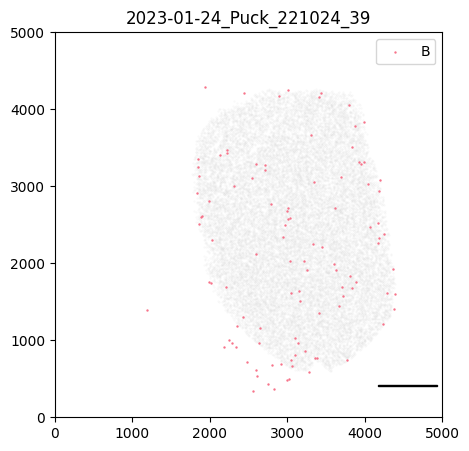

 20%|█████████████████████                                                                                    | 1/5 [00:01<00:06,  1.52s/it]/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:603: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)


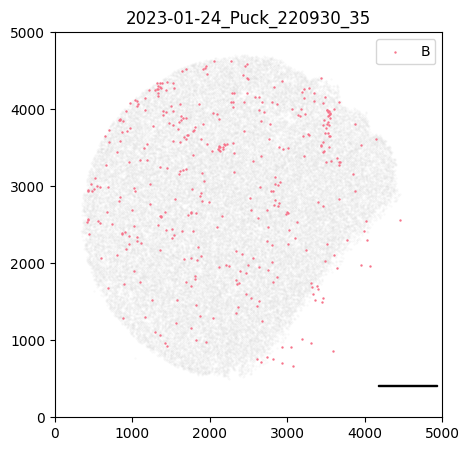

 40%|██████████████████████████████████████████                                                               | 2/5 [00:03<00:05,  1.79s/it]/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:603: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)


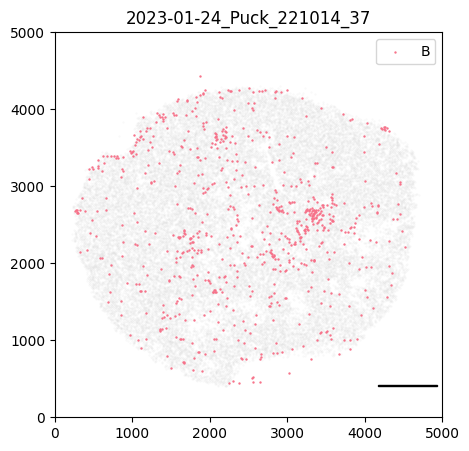

 60%|███████████████████████████████████████████████████████████████                                          | 3/5 [00:05<00:03,  1.68s/it]/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:603: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)


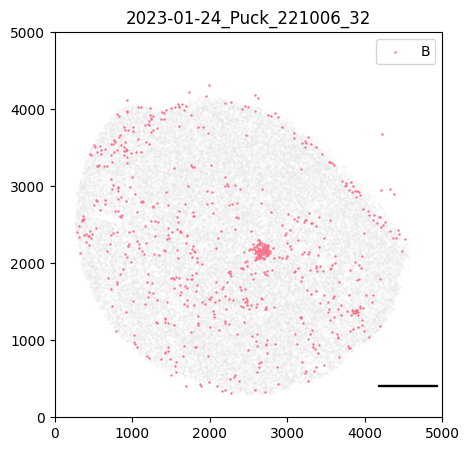

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 4/5 [00:06<00:01,  1.73s/it]/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_83930/1924293917.py:603: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)


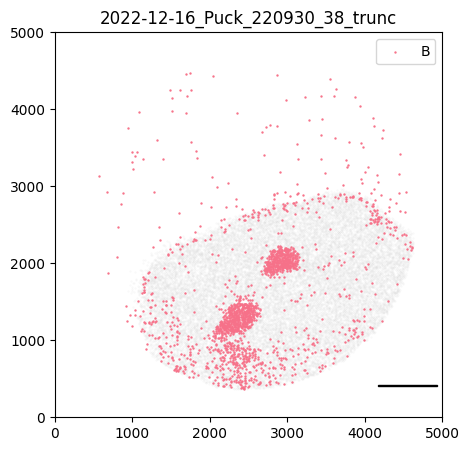

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


In [10]:
# Load all rctd
puck_names_use = representative_puck_names

adata_all = {}
rctd_all = {}

for slideseq_name in tqdm(puck_names_use):
    b = puck_to_batch[slideseq_name]
    adata = adata_combined[adata_combined.obs.Batch == b+1]
    rctd_results = pd.read_csv(f'{directory}RCTD_results.csv')
    rctd_results = rctd_results[rctd_results.puck_name == slideseq_name]
    adata_all[slideseq_name] = adata
    rctd_all[slideseq_name] = rctd_results

    # Plot B cells
    plot_cell_types(adata, rctd_results, cell_type_list=['B'], title=slideseq_name,
                   title_save = f'S2C_{slideseq_name}')


## S2D

In [11]:
adata = copy.deepcopy(adata_raw)

In [12]:
def run_analysis(gs):
    gene_sets = {
        'mature_b_gs': ['Igkc', 'Ms4a1', 'Cd20', 'Cd19', 'Cd22', 'Cd27'],
        'prog_b_gs': ['Vpreb1', 'Vpreb3', 'Ebf1', 'Pax5'],
        'age_b_gs': ['Itgax', 'Tbx21']
    }

    if gs not in gene_sets:
        raise ValueError('Invalid gene set name provided.')

    gs_use = gene_sets[gs]
    region = 'both'

    # Filter for cortex and medulla once
    adata_filtered = adata_raw[adata_raw.obs.cortex_medulla.isin(['cortex', 'medulla'])]

    # Pre-filter genes
    adata_eos = adata_filtered[:, adata_filtered.var_names.isin(gs_use)]
    
    # Check if sparse matrix
    is_sparse = scipy.sparse.issparse(adata_eos.X)

    # Get unique batch numbers efficiently
    batches = adata_eos.obs.Batch.unique()

    batch_num_plot = []
    frac_of_cells_eos = []

    for batch in tqdm(batches):
        adata_puck = adata_eos[adata_eos.obs.Batch == batch]

        # Further filter based on the region (avoid redundant reassignments)
        if region != 'both':
            adata_puck = adata_puck[adata_puck.obs.cortex_medulla == region]

        # Efficiently sum expression values
        val = adata_puck.X.sum(axis=1).A1 if is_sparse else adata_puck.X.sum(axis=1)

        # Extract x, y coordinates
        x_coords = adata_puck.obs.x.values
        y_coords = adata_puck.obs.y.values

        # Filter points with expression > 0
        mask = val > 0
        if not np.any(mask):
            continue

        x_pass = x_coords[mask]
        y_pass = y_coords[mask]

        # Store fraction of cells with expression
        frac_of_cells_eos.append(len(x_pass) / len(x_coords))
        batch_num_plot.append(batch)

    # Skip if no valid data
    if not batch_num_plot:
        print(f"No data for {gs}")
        return

    # Convert batch numbers to time points
    x = [batch_to_tpt[i] for i in batch_num_plot]
    y = frac_of_cells_eos

    # Aggregate duplicate x values
    unique_data = defaultdict(list)
    for xi, yi in zip(x, y):
        unique_data[xi].append(yi)

    unique_x = np.array(sorted(unique_data.keys()))
    unique_y = np.array([np.mean(unique_data[xi]) for xi in unique_x])

    # Fit polynomial regression (use `polyfit` for efficiency)
    degree = 1
    poly_coefs = np.polyfit(unique_x, unique_y, degree)
    poly_fit = np.poly1d(poly_coefs)

    # Generate smooth polynomial curve
    x_smooth = np.linspace(unique_x.min(), unique_x.max(), 500)
    y_smooth = poly_fit(x_smooth)

    # Plot results
    fig, ax = plt.subplots()
    plt.scatter(x, y, c='k', label='Data Points')
    plt.plot(x_smooth, y_smooth, color='red', label=f'Polynomial Fit (degree {degree})')

    # Configure x-axis as log scale
    ax.set_xscale('log', base=10)
    ax.set_xticks([1, 5, 10, 100, 500])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # Save and show plot
    plt.title(f'{gs}_{region}')
    plt.legend()
    plt.savefig(f'{output_directory}S2D_{gs}.pdf')
    plt.show()

    # Pearson correlation
    correlation = scipy.stats.pearsonr(x, y)
    print(f"Gene set: {gs}, Pearson correlation coefficient and p-value: {correlation}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.46it/s]


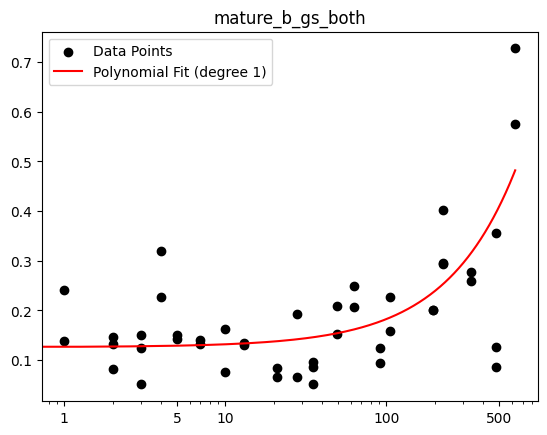

Gene set: mature_b_gs, Pearson correlation coefficient and p-value: PearsonRResult(statistic=0.6957682512759146, pvalue=5.674669826113129e-08)


<Figure size 640x480 with 0 Axes>

In [13]:
run_analysis('mature_b_gs')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.00it/s]


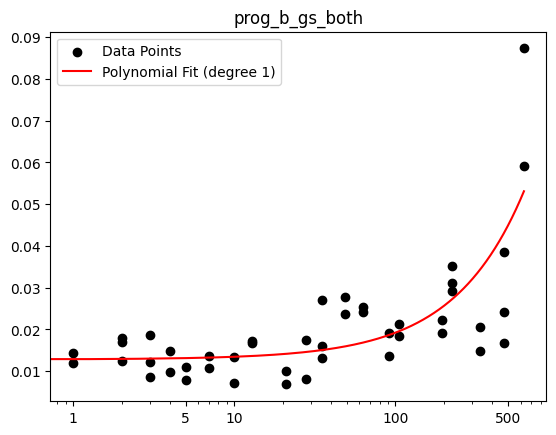

Gene set: prog_b_gs, Pearson correlation coefficient and p-value: PearsonRResult(statistic=0.7473676671393253, pvalue=1.5922221520240456e-09)


<Figure size 640x480 with 0 Axes>

In [14]:
run_analysis('prog_b_gs')